# bertrand2025/figure3
Plot figure 3 from Bertrand et al. 2025, "Increasing wintertime cloud opacity increases surface longwave radiation at a long-term  Arctic observatory".

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrow
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import interpolate
import statsmodels.formula.api as smf
import statsmodels.api as sm

#from load_preproc_nb40 import load_arm_temp, load_abo_temp, nanmean, load_minutely_flux_hists
from prep_basecase_nb44 import *
from analyze_by_basecase_nb48 import *

from IPython.display import display, Math

In [2]:
declim = lambda ds: ds.groupby('time.month') - ds.groupby('time.month').mean()
#subset to DJFM
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))

# 2. base cases

In [3]:
# load weights f
da_weights_djfm = xr.open_dataset('cloud_phase_monthly_frequency.nc')
da_weights_djfm = da_weights_djfm['weights']
da_weights_avg  = da_weights_djfm.mean('time')

In [4]:
# load base case specification datasets
spec_met = xr.open_dataset('46-1-base_cases_met.nc')
spec_cld = xr.open_dataset('46-1-base_cases_cld.nc')
spec = xr.merge([spec_met,spec_cld])
cloudy = xr.DataArray(data=[True,True,True,False],dims=['type'],
                      coords={'type':np.array(['liquid', 'mixed', 'ice','clear'])})
spec = spec.assign(is_cloudy=cloudy)

In [5]:
attributed_err_by_case = xr.open_dataset('drivers_by_type_error.nc')
attributed_med_by_case = xr.open_dataset('drivers_by_type.nc')
attrib_tot_med = xr.open_dataset('allsky_attributed_driving.nc')
attrib_tot_err = xr.open_dataset('allsky_attributed_driving_error.nc')

In [6]:
long_names = {
    'tot_cld': 'Cloud cover',
    'liq_cld': 'Cloud phase',
    'lwp': 'Liquid water path',
    'pwv': 'Water vapor',
    'pwv_cc': r'PWV$_\mathrm{CC}$',
    'Temp_Air': 'Air temperature',
    'temp': r'$T_{2m}$',
    'planck': 'Planck',
    'column_air_temperature': r'Lapse rate',
    'cbh': r'Cloud altitude',
    'twp': r'Cloud water path',
    'iwp': 'Ice water path',
    'iwphi': 'Opaque ice water path',
    'cloud_liquid': r'$f_{liq}$',
    'cloud_mixed': r'$f_{mix}$',
    'cloud_ice': r'$f_{ice}$',
    'co2': r'Direct CO$_2$',
    'lwu': r'$F_U$',
    'lwd': r'$F_D$',
    'lwn': r'$F_N$',
    'total':'Total'
}

In [7]:
da_med = attrib_tot_med.to_array()
da_hi  = attrib_tot_med.to_array()+attrib_tot_err.to_array()
da_lo  = attrib_tot_med.to_array()-attrib_tot_err.to_array()

### 3.3.1 get numbers that go in the figure write-up

# 4. net longwave by cumulative drivers
Add predicted net by base case as semitransparent lines with the same color coding? Does that make any sense? I think on a basic level the stacked bar chart won't work anymore because the signs of various things will become confusing. But maybe it could work somehow. I feel like the cleanness of the four traces could work better even though the presentation is unusual.

## 4.2 LWN simple sums by base case
'Planck', 'All non-cloud', 'All', and 'total'. Should I keep the cumulative sum graphical scheme? Like 'Planck', '+ Other non-cloud' (WV, LR, CO$_2$), '+ cloud', and then 'total' or 'constraint'. And the dual y-axes? Like inferred and direct, or inferred and observed, or attributed and constraint?

In [8]:
def prepend_tot(ds_by_case,ds_tot,dim='type'):
    return xr.concat([ds_tot.assign_coords({dim:'total'}),ds_by_case],dim=dim)
def append_tot(ds_by_case,ds_tot,dim='type'):
    return xr.concat([ds_by_case,ds_tot.assign_coords({dim:'total'})],dim=dim)

In [9]:
attributed_med = xr.open_dataset('driving_by_driver.nc')
attributed_err = xr.open_dataset('drivers_by_type_error.nc')
attributed_med_by_case = xr.open_dataset('drivers_by_type.nc')
attributed_err_by_case = xr.open_dataset('drivers_by_type_error.nc')
dxdt_med = xr.open_dataset('feature_response_to_temperature.nc')
dxdt_err = xr.open_dataset('feature_response_to_temperature_error.nc')
dxdt_hi = dxdt_med + dxdt_err
dxdt_lo = dxdt_med - dxdt_err

In [10]:
attributed_med_all = append_tot(attributed_med,attrib_tot_med)
attributed_err_all = append_tot(attributed_err,attrib_tot_err)

In [11]:
def get_lwn_csum(which,categories='simple',append_radtotal=True):
    ERROR_PROPAGATION = 'QUAD_NAIVE' #'LINEAR','QUAD_NAIVE'
    if which != 'total':
        attributed_med_all_i = attributed_med_all.drop_vars('tot_cld')
        attributed_err_all_i = attributed_err_all.drop_vars('tot_cld')
    else:
        attributed_med_all_i = attributed_med_all
        attributed_err_all_i = attributed_err_all
    if which == 'total':
        which_i = 'all'
    else:
        which_i = which
    da_med = attributed_med_all_i.sel(type=which).to_array()
    da_err = attributed_err_all_i.sel(type=which).to_array()
    da_hi  = da_med+da_err
    da_lo  = da_med-da_err

    #subtract lwu from first value to convert to lwn
    #med
    arr = da_med.data.copy()
    arr[0] = arr[0]-dxdt_med['lwu'].sel(type=which_i)
    da_med.data = arr
    #hi
    arr = da_hi.data.copy()
    arr[0] = arr[0]-dxdt_hi['lwu'].sel(type=which_i)
    da_hi.data = arr
    #lo
    arr = da_lo.data.copy()
    arr[0] = arr[0]-dxdt_lo['lwu'].sel(type=which_i)
    da_lo.data = arr
    #cumulative sum by feature
    csum_med = da_med.cumsum('variable')
    if ERROR_PROPAGATION == 'LINEAR':
        csum_hi  = da_hi.cumsum('variable')
        csum_lo  = da_lo.cumsum('variable')
    elif ERROR_PROPAGATION == 'QUAD_NAIVE':
        #get standard error from confidence interval
        alpha = 0.05 #95% CI
        df = 44 #shupeturner number of DJFM months minus 1
        q = stats.t.ppf(1 - alpha / 2, df)
        bse_1 = np.abs(da_med-da_lo)/q
        bse_2 = np.abs(da_hi-da_med)/q
        bse = 0.5*(bse_1+bse_2) #symmetrize CI
        #propagate standard errors
        csum_yerr = np.sqrt((bse**2).cumsum('variable'))
        #back to CI
        csum_lo = csum_med-q*csum_yerr
        csum_hi = csum_med+q*csum_yerr
    
    #convert to simplified categories
    if categories == 'simple':
        csum_med = csum_med.sel(variable=['planck','column_air_temperature','cbh'])
        csum_lo  = csum_lo.sel(variable=['planck','column_air_temperature','cbh'])
        csum_hi  = csum_hi.sel(variable=['planck','column_air_temperature','cbh'])

    #get direct observed radiometric response
    dxdt_med_i = dxdt_med['lwn'].sel(type=which_i)
    dxdt_err_i = dxdt_err['lwn'].sel(type=which_i)
    dxdt_hi_i  = dxdt_med_i + dxdt_err_i
    dxdt_lo_i  = dxdt_med_i - dxdt_err_i

    if append_radtotal:
        csum_med   = append_tot(csum_med,dxdt_med_i,dim='variable')
        csum_lo    = append_tot(csum_lo,dxdt_lo_i,dim='variable')
        csum_hi    = append_tot(csum_hi,dxdt_hi_i,dim='variable')

    drop_cbh = lambda da: da.sel(variable=da['variable'] != 'cbh')
    
    if which == 'clear':
        csum_med = drop_cbh(csum_med)
        csum_lo  = drop_cbh(csum_lo)
        csum_hi  = drop_cbh(csum_hi)

    return csum_med, csum_lo, csum_hi

In [12]:
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
bar_kws      = {'alpha':0.7,'edgecolor':'k','linewidth':0.5}

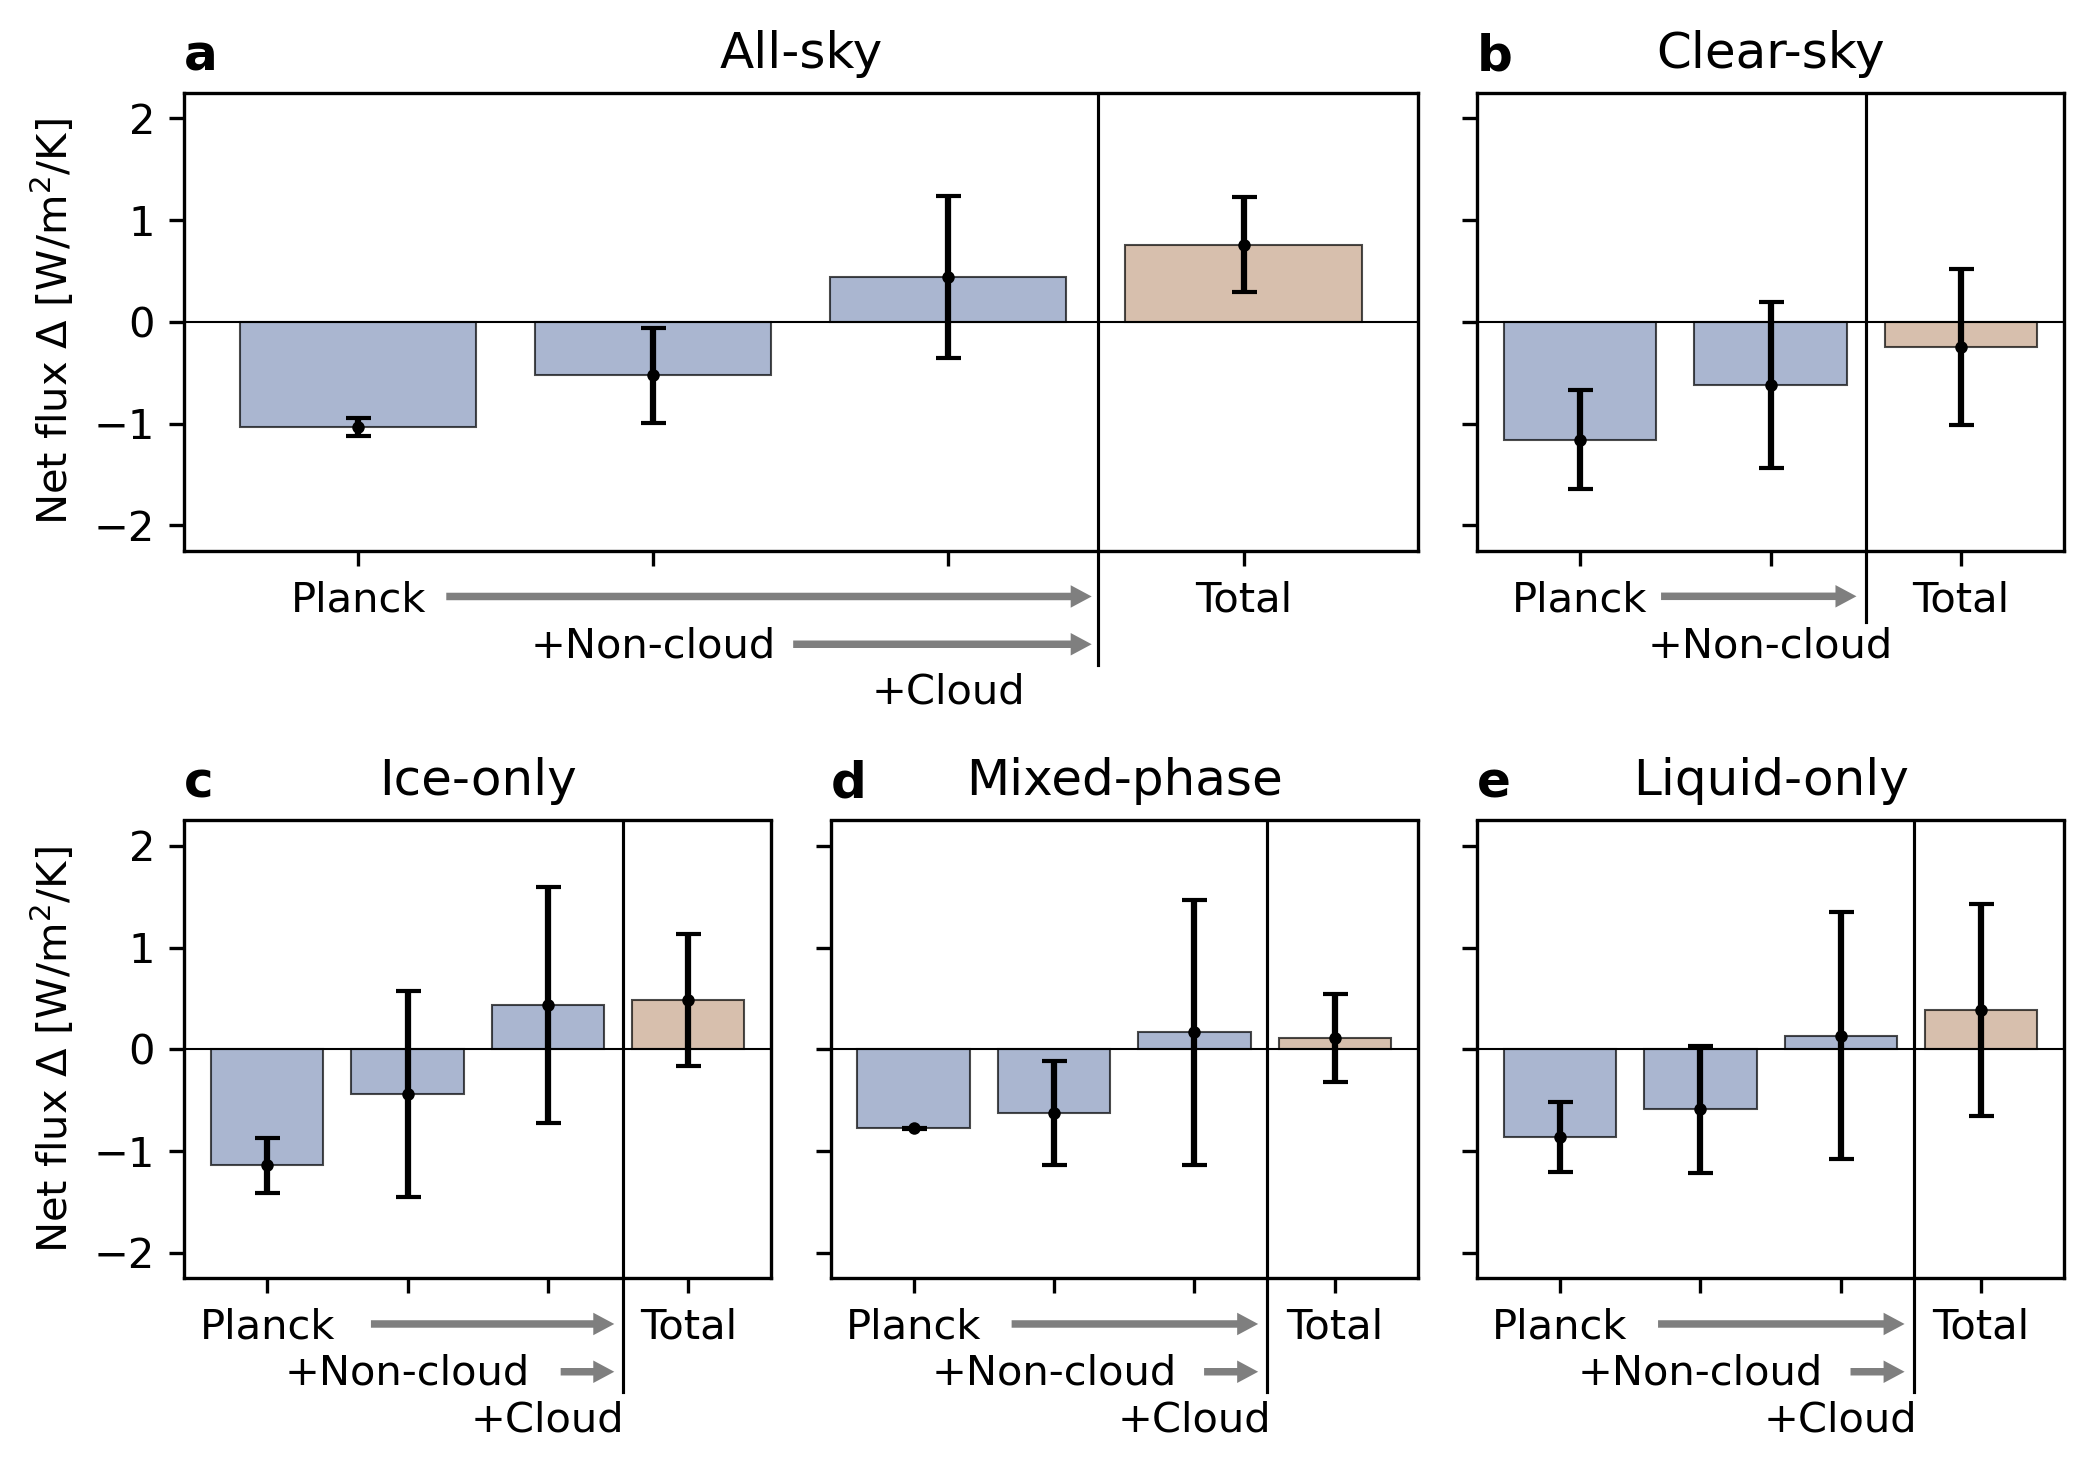

In [13]:
fig,axes = plt.subplots(2,3,dpi=300,figsize=(7,5),sharey=True,height_ratios=[1,1])
colors = ['#8698BD','#8698BD','#8698BD','#C6A48A','darkgrey'] #orange, blue, grey

#turn second row into one long axis
gs = axes[0, 0].get_gridspec()
# remove the underlying Axes
for ax in axes[0, :2]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :2])

axlist = [axbig,*axes.flatten()[2:]]

long_type_names = {'mixed': 'Mixed-phase',
                   'ice':'Ice-only',
                   'liquid':'Liquid-only',
                   'clear':'Clear-sky',
                   'total':'All-sky'}


for ax,which in zip(axlist,['total','clear','ice','mixed','liquid']):        
    #bar
    csum_med, csum_lo, csum_hi = get_lwn_csum(which)
    if which == 'clear':
        labels = ['Planck','Non-cloud','Total']
    else:
        labels = ['Planck','Non-cloud','Cloud','Total']
    labels_cr = [(i*'\n')+'+'+s for i,s in enumerate(labels)]
    labels_cr[0] = labels_cr[0][1:]
    labels_cr[-1] = labels[-1]
    icolors = colors[1:] if which == 'clear' else colors
    ax.bar(labels_cr,csum_med,bottom=0,color=icolors,**bar_kws)
    #errorbar     
    yerr = [np.abs(csum_hi-csum_med), np.abs(csum_med-csum_lo)]
    ax.errorbar(labels_cr,csum_med,yerr=yerr,**errorbar_kws)
    ax.set_title(long_type_names[which])
    ax.axhline(0,c='k',lw=0.5,alpha=1)


fig.tight_layout()
axbig.set_ylim([-2.25,2.25])
axes[1,0].set_ylim([-2.25,2.25])
axbig.set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[1,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axlist:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
#add arrows
#regular ones
for ax in axlist[2:]:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    if ax in [axbig,axes[1,0]]:
        x0 = x0+0.2*dx
        dx = dx*0.8
    xx = [x0+0.325*dx,x0+0.645*dx]
    yy = [y0+0.17*dy,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        x,y = np.array([[xi, 0.8], [yi, yi]])
        line = FancyArrow(xi, yi, x0+0.7*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.75*dx,x0+0.75*dx],[y0+0.07*dy,0.91*y1],c='k',lw=0.75)
    fig.add_artist(line)

#all-sky
ax = axbig
if True:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    xx = [x0+0.3*dx,x0+0.55*dx]
    yy = [y0+0.17*dy,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        x,y = np.array([[xi, 0.8], [yi, yi]])
        line = FancyArrow(xi, yi, x0+0.75*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.77*dx,x0+0.77*dx],[y0+0.07*dy,0.955*y1],c='k',lw=0.75)
    fig.add_artist(line)

#clear-sky
ax = axlist[1]
if True:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    xx = [x0+0.33*dx]#,x0+0.55*dx]
    yy = [y0+0.11*dy]#,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        line = FancyArrow(xi, yi, x0+0.62*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.67*dx,x0+0.67*dx],[y0+0.07*dy,0.955*y1],c='k',lw=0.75)
    fig.add_artist(line)
#fig.savefig('67-2-fig03_bertrand2025_R2R_tweaks.pdf',bbox_inches='tight')

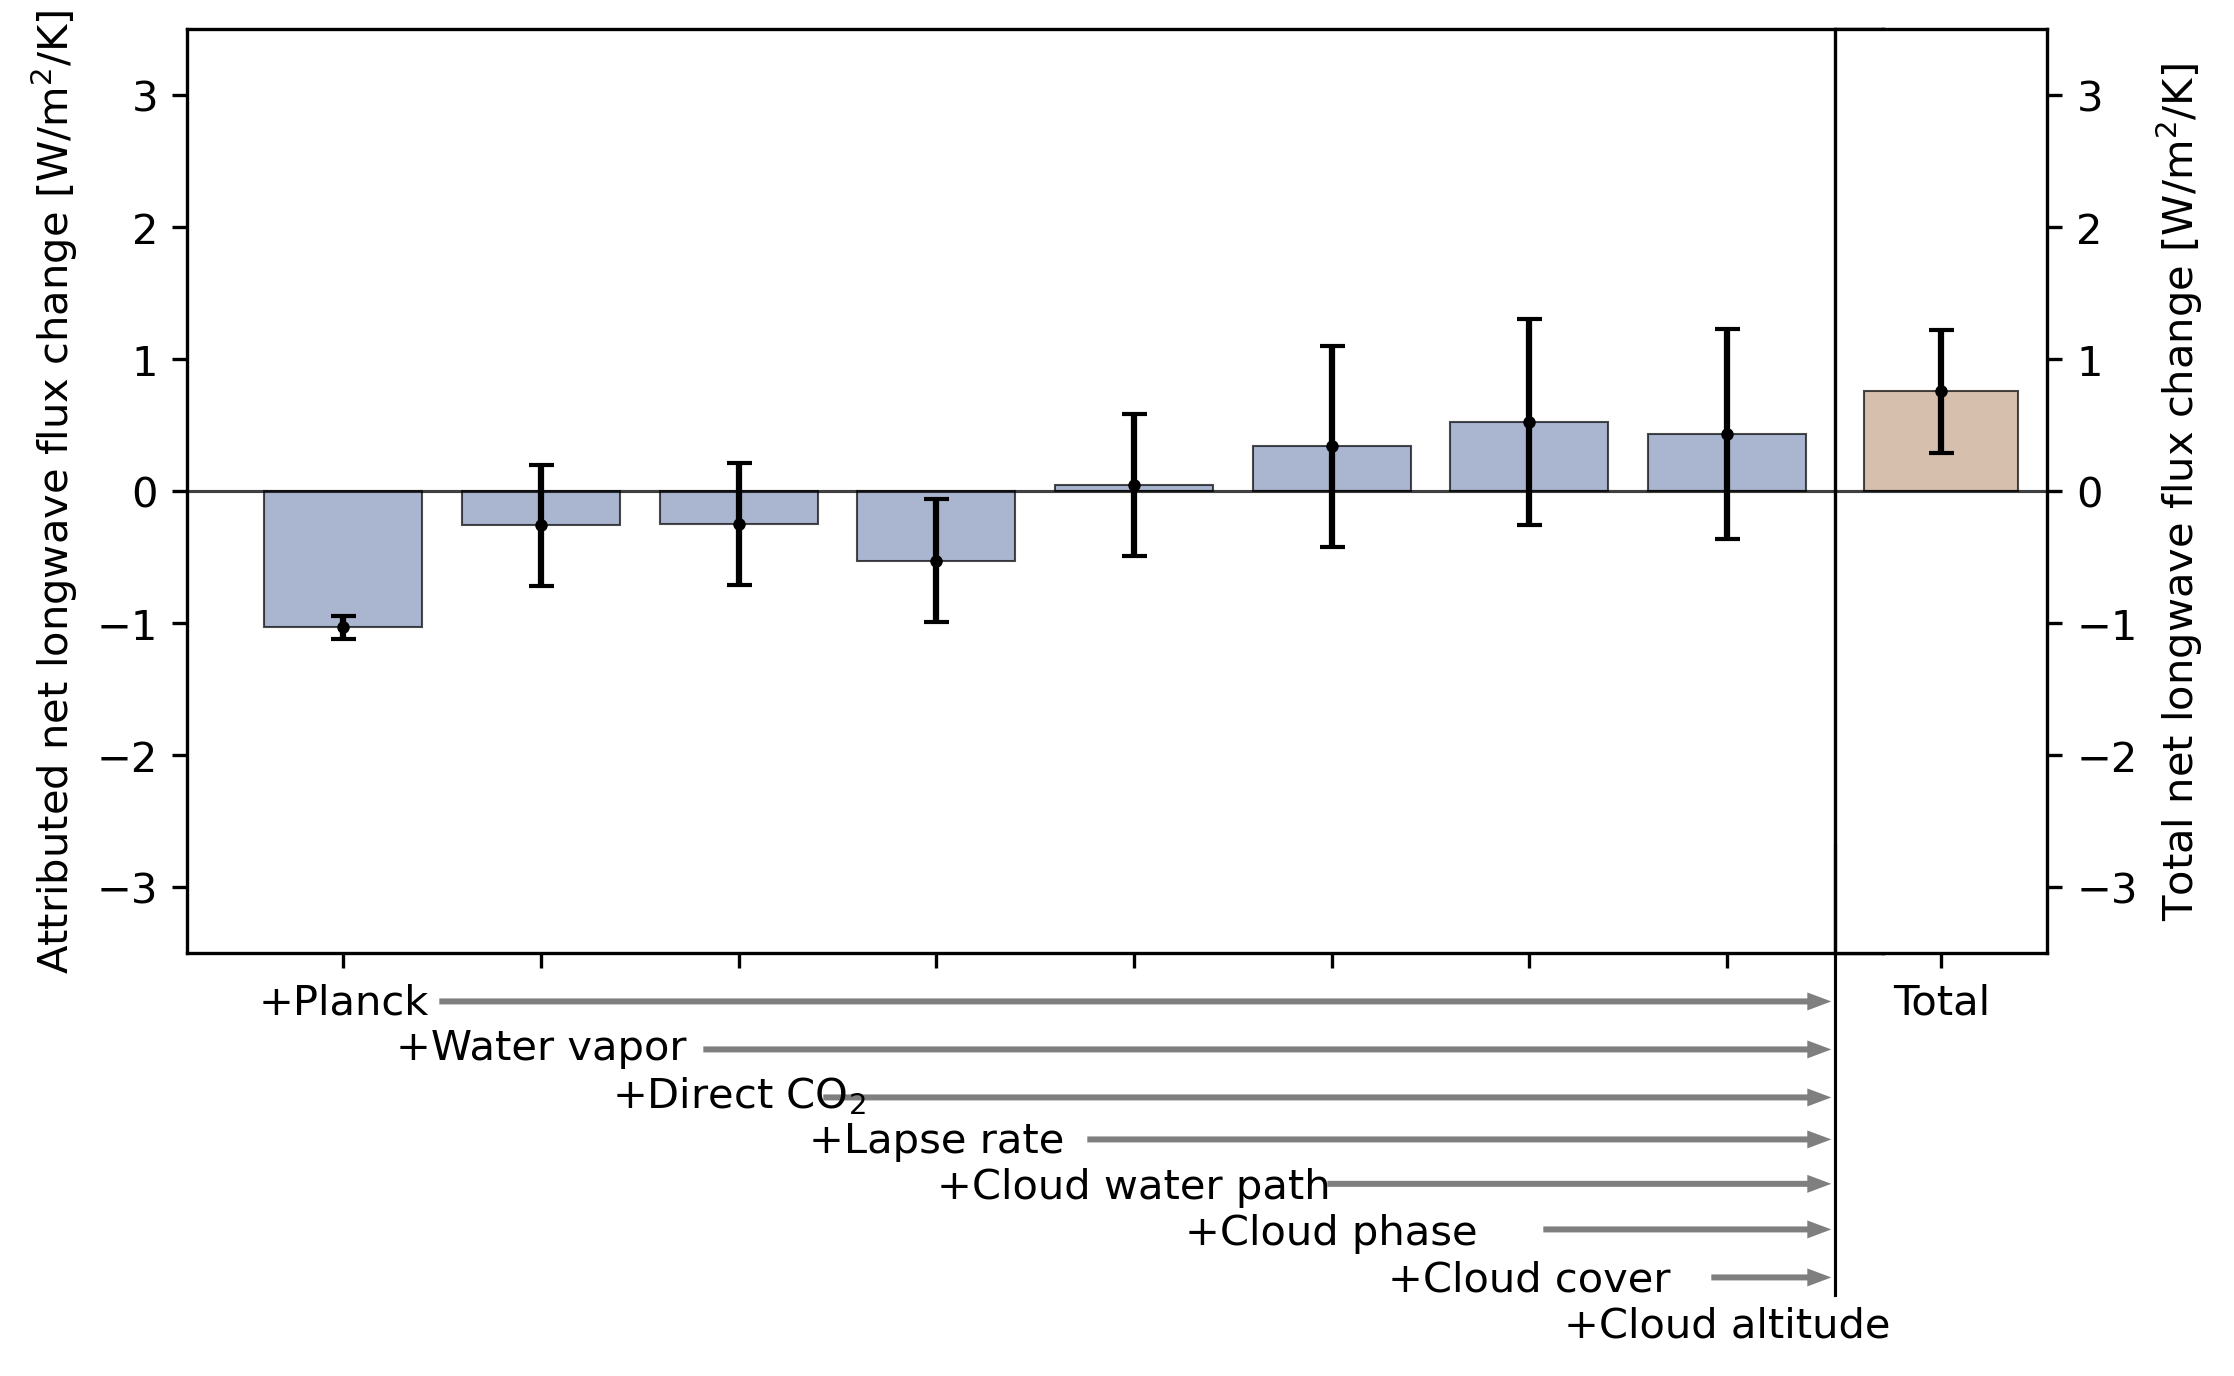

In [14]:
ERROR_PROPAGATION = 'QUAD_NAIVE' #'LINEAR','QUAD_NAIVE'

fig, axes = plt.subplots(1,2,sharex=False,sharey=False,figsize=(8,4),dpi=300,width_ratios=[8,1])
ax = axes[0]
colors = ['#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#C6A48A','darkgrey'] #orange, blue, grey
csum_med, csum_lo, csum_hi = get_lwn_csum('total',categories='complex',append_radtotal=False)

#bar
labels = [long_names[key] for key in da_med.coords['variable'].data]
labels_cr = [(i*'\n')+'+'+s for i,s in enumerate(labels)]
ax.bar(labels_cr,csum_med,bottom=0,color=colors,**bar_kws)
# ax.bar(labels,width=0.8,bottom=csum_med.shift(variable=1),height=da_med,
#        facecolor='salmon',alpha=0.3,edgecolor='k',linewidth=0.5)
#errorbar     
yerr = [np.abs(csum_hi-csum_med), np.abs(csum_med-csum_lo)]
ax.errorbar(labels_cr,csum_med,yerr=yerr,**errorbar_kws)
#labels
ax.set_ylabel('Attributed net longwave flux change [W/m$^2$/K]')
if ax.get_ylim()[0]<=0.0:
    ax.axhline(0,c='k',lw=0.75,alpha=0.75)
#ax.text(0.02,0.055,'Cumulative sum$\longrightarrow$',transform=ax.transAxes)
# for label in ax.get_xticklabels():
#     label.set_ha("left")
#     label.set_rotation(-30)
ax.set_ylim(-3.5,3.5)
#raw total from radiometer
ax = axes[1]
hi, med, lo = dxdt_hi['lwn'].sel(type='all'), dxdt_med['lwn'].sel(type='all'), dxdt_lo['lwn'].sel(type='all')
hi, med, lo = hi.data[np.newaxis], med.data[np.newaxis], lo.data[np.newaxis]
ax.bar(['Total'],med,width=0.725,color='#C6A48A',**bar_kws)
yerr = [np.abs(hi-med), np.abs(med-lo)]
ax.errorbar(['Total'],med,yerr=yerr,**errorbar_kws)
ax.set_xlim(-0.5,0.5)
if ax.get_ylim()[0]<=0.0:
    ax.axhline(0,c='k',lw=0.75,alpha=0.75)
ax.set_ylabel('Total net longwave flux change [W/m$^2$/K]')
# for label in ax.get_xticklabels():
#     label.set_ha("left")
#     label.set_rotation(-30)
ax.set_ylim(*axes[0].get_ylim())
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
fig.subplots_adjust(wspace=-0.05)
#fig.tight_layout()
xx = [0.23,0.34,0.39,0.5,0.6,0.69,0.76]
yy = [0.07,0.03,-0.01,-0.045,-0.082,-0.12,-0.16]
for xi,yi in zip(xx,yy):
    x,y = np.array([[xi, 0.8], [yi, yi]])
    line = FancyArrow(xi, yi, 0.8-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
    fig.add_artist(line)
line = Line2D([0.8115,0.8115],[-0.175,0.2],c='k',lw=0.75)
fig.add_artist(line)
#fig.savefig('60-net_longwave_sum_linegrow_allsky_OLS_newboot_complex_neworder2.pdf',bbox_inches='tight')